In [ ]:
#Description: A COVID-19 vaccine sentiment analysis program that parses tweets using Python

**Importing all the projects' dependencies**

In [ ]:
# Import libraries to be used
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as pyo
import warnings
warnings.filterwarnings("ignore")

from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud
from string import punctuation
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from textblob import TextBlob

!pip install vaderSentiment
!pip install twython
!pip install --upgrade plotly

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


**Loading the CSV we will be using**

In [ ]:
# Loading the data
df = pd.read_csv('vaccination_tweets.csv')
df.head()


,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0.0,0.0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1.0,1.0,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0.0,0.0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446.0,2129.0,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0.0,0.0,False


In [ ]:
# Datatype info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7593 entries, 0 to 7592
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                7593 non-null   int64  
 1   user_name         7593 non-null   object 
 2   user_location     6060 non-null   object 
 3   user_description  7110 non-null   object 
 4   user_created      7593 non-null   object 
 5   user_followers    7593 non-null   int64  
 6   user_friends      7593 non-null   int64  
 7   user_favourites   7593 non-null   int64  
 8   user_verified     7593 non-null   bool   
 9   date              7593 non-null   object 
 10  text              7593 non-null   object 
 11  hashtags          5732 non-null   object 
 12  source            7591 non-null   object 
 13  retweets          7592 non-null   float64
 14  favorites         7592 non-null   float64
 15  is_retweet        7592 non-null   object 
dtypes: bool(1), float64(2), int64(4), object(9

**Cleaning the tweets to only display its contained text**

In [ ]:
# Cleaning tweets to display only its tweet
def clean(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    return text

**Reading subtext through analysing 100 hashtags**

In [ ]:
# For all var a in datafile in category hashtags, remove separating brackets and split at , to get text
df['hashtags']=df['hashtags'].fillna('[]')
all_hashtags=[]
for i in range(len(df['hashtags'])):
    a=df['hashtags'][i].strip('][').split(', ') 
    for i in a:
        all_hashtags.append(i)
all_hashtags=['No Hashtag' if x=='' else x for x in all_hashtags] # If '' then no hashtags.      

all_hashtags=pd.Series(np.array(all_hashtags))
print('{} tweets out of 11021 are posted without a hashtag.'.format(all_hashtags.value_counts()[1]))

# Using a tree map to display 100 most common hashtags overall
common_hashtags=all_hashtags.value_counts().drop(labels='No Hashtag')[:100].rename_axis('Common Hashtags').reset_index(name='count')
fig = px.treemap(common_hashtags, path=['Common Hashtags'], values='count',title='100 Most Common Hashtags')
fig.show()

1861 tweets out of 11021 are posted without a hashtag.


In [ ]:
# Positive sentiments 50 most common words
Positive_tweet = df[df['Sentiment']=='Positive'].reset_index()
Negative_tweet = df[df['Sentiment']=='Negative'].reset_index()

# For all var a in datafile in category hashtags, from postive tweets, remove separating brackets and split at , to get text
all_positive_hashtags=[]
for i in range(len(Positive_tweet['text'])):
    a=Positive_tweet['hashtags'][i].strip('][').split(', ')
    
    for i in a:
        all_positive_hashtags.append(i)

all_positive_hashtags=pd.Series(np.array(all_positive_hashtags))

# Using a tree map to display 100 most common hashtags in positive tweets
common_hashtags=all_positive_hashtags.value_counts()[:100].drop(labels='').rename_axis('Common Positive Hashtags').reset_index(name='count')
fig = px.treemap(common_hashtags, path=['Common Positive Hashtags'], values='count',title='100 Most Common Positive Hashtags')
fig.show()

KeyError: ignored

In [ ]:
# For all var a in datafile in category hashtags, from negative tweets, remove separating brackets and split at , to get text
all_negative_hashtags=[]
for i in range(len(Negative_tweet['text'])):
    a=Negative_tweet['hashtags'][i].strip('][').split(', ')
    
    for i in a:
        all_negative_hashtags.append(i)
all_negative_hashtags=pd.Series(np.array(all_negative_hashtags))

# Using a tree map to display 100 most common hashtags in negative tweets
common_hashtags=all_negative_hashtags.value_counts()[:100].drop(labels='').rename_axis('Common Negative Hashtags').reset_index(name='count')
fig = px.treemap(common_hashtags, path=['Common Negative Hashtags'], values='count',title='100 Most Common Negative Hashtags')
fig.show()

NameError: ignored

**Sentiment checks using VADER and TextBlob**

In [ ]:
# Cleaned result
df['Clean_Tweets']= df['text'].apply(clean)

In [ ]:
# Using the VADER sentiment analysis
analyser= SentimentIntensityAnalyzer() 

def get_vader_sentiment(sent):
    return analyser.polarity_scores(sent)['compound']

df['sent_vader']= df['Clean_Tweets'].apply(get_vader_sentiment)

# Sentiment prediction; positive if >0.05, negative if <-0.05, neutral in between.
sent_pred=[]
for i in range(len(df['sent_vader'])):
    if df['sent_vader'][i]>=0.05:
        sent_pred.append('positive')
    elif df['sent_vader'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

# Using the CSVs data to predict sentiment by VADER
df['sent_pred']= sent_pred

In [ ]:
# Using TextBlob
def get_textblob_sentiment(sent):
    return TextBlob(sent).sentiment.polarity


df['sent_TextBlob']= df['Clean_Tweets'].apply(get_textblob_sentiment)

# Sentiment prediction; positive if >0.05, negative if <-0.05, neutral in between.
sent_pred=[]
for i in range(len(df['sent_TextBlob'])):
    if df['sent_TextBlob'][i]>=0.05:
        sent_pred.append('positive')
    elif df['sent_TextBlob'][i]<=-0.05:
        sent_pred.append('negative')
    else:
        sent_pred.append('neutral')  

# Using the CSVs data to predict sentiment by TextBlob method
df['sent_predTextBlob']= sent_pred

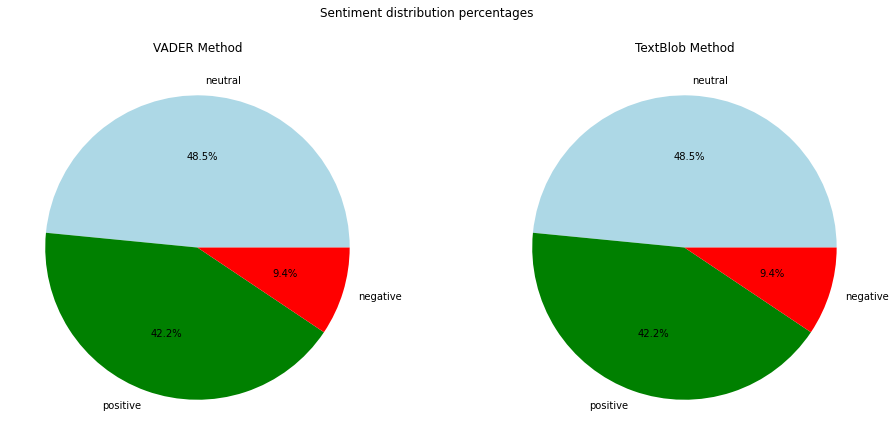

In [ ]:
# Classifying tweets(df) into categories (negative, neutral, positive) with percentages
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Sentiment distribution percentages')

# For VADER
per = pd.DataFrame((df['sent_pred'].value_counts()/len(df))*100)
per.reset_index(inplace=True)
per.columns = ['Sentiment','Percentage']

# For TextBlob
perc = pd.DataFrame((df['sent_predTextBlob'].value_counts()/len(df))*100)
perc.reset_index(inplace=True)
perc.columns = ['Sentiment','Percentage']

# VADER pie chart
axes[0].pie(perc['Percentage'],
        labels=per['Sentiment'],
        autopct='%1.1f%%',
        colors=['lightblue','green','red'])
axes[0].set_title("VADER Method")

# TextBlob piechart
axes[1].pie(perc['Percentage'],
        labels=perc['Sentiment'],
        autopct='%1.1f%%',
        colors=['lightblue','green','red'])
axes[1].set_title("TextBlob Method")

# Show the pie charts
fig.show()



In [ ]:
# Showing the raw numbers of the sentiment percentages.

temp = df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=True)
temp.style.background_gradient(cmap='Blues')

KeyError: ignored

**Favorite counts by tweet sentiment**

Text(0.5, 1.0, 'TextBlob Method')

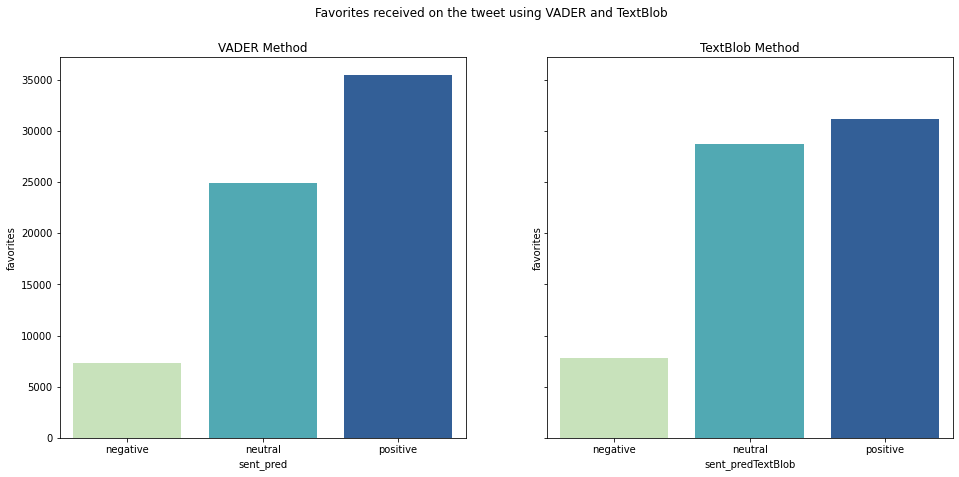

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Favorites received on the tweet using VADER and TextBlob')

# VADER bar plot to sum up favorites of tweets with certain sentiments.
a = pd.DataFrame(df.groupby(['sent_pred'])['favorites'].sum())
sns.barplot(ax=axes[0], x=a.index, y=a['favorites'], palette= 'YlGnBu')
axes[0].set_title("VADER Method")
fig.show()

# TextBlob bar plot to sum up favorites with certain sentiments
b = pd.DataFrame(df.groupby(['sent_predTextBlob'])['favorites'].sum())
sns.barplot(ax=axes[1], x=b.index, y=b['favorites'], palette= 'YlGnBu')
axes[1].set_title("TextBlob Method")

**Retweets counts by tweet sentiment**

Text(0.5, 1.0, 'TextBlob Method')

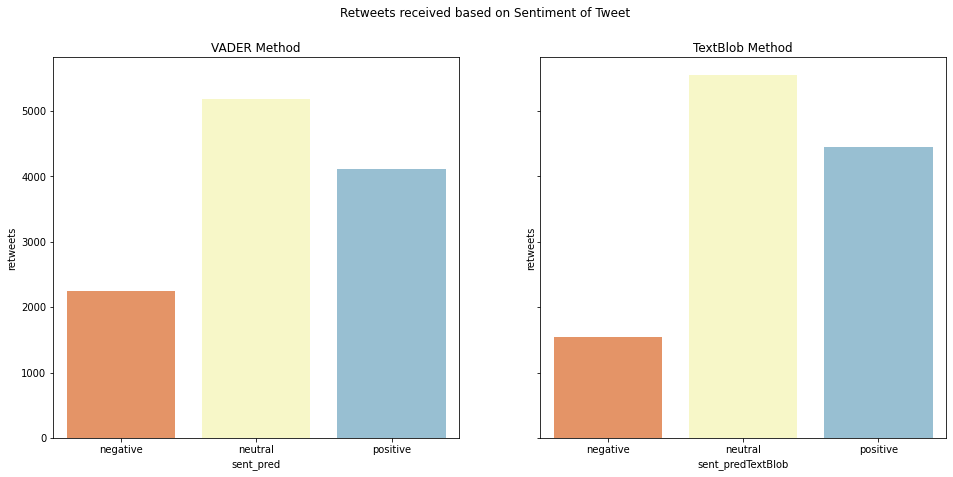

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
fig.suptitle('Retweets received based on Sentiment of Tweet')

# VADER bar plot to sum up retweets gained by tweets with negative neutral or positive sentiment
a = pd.DataFrame(df.groupby(['sent_pred'])['retweets'].sum())
sns.barplot(ax=axes[0], x=a.index, y=a['retweets'], palette= 'RdYlBu')
axes[0].set_title("VADER Method")
fig.show()

# TextBlob bar plot to sum up retweets gained by tweets with negative neutral or positive sentiment
b = pd.DataFrame(df.groupby(['sent_predTextBlob'])['retweets'].sum())
sns.barplot(ax=axes[1], x=b.index, y=b['retweets'], palette= 'RdYlBu')
axes[1].set_title("TextBlob Method")

**Unique symbols in tweets by sentiment**

In [ ]:
# First take all the negative tweets and their text (hashtags and all)
all_negative_words=[]
all_negative_hashtags=[]
for i in range(len(Negative_tweet['text'])):
    a=Negative_tweet['text'][i]
    b=Negative_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_negative_words.append(i)
    for i in b:
        all_negative_hashtags.append(i)
all_negative_words=pd.Series(np.array(all_negative_words))
all_negative_hashtags=pd.Series(np.array(all_negative_hashtags))

# Then take all the positive tweets and their text (hashtags and all)
all_positive_words=[]
all_positive_hashtags=[]
for i in range(len(Positive_tweet['text'])):
    a=Positive_tweet['text'][i]
    b=Positive_tweet['hashtags'][i].strip('][').split(', ')
    for i in a:
        all_positive_words.append(i)
    for i in b:
        all_positive_hashtags.append(i)
all_positive_words=pd.Series(np.array(all_positive_words))
all_positive_hashtags=pd.Series(np.array(all_positive_hashtags))

# Take all the one common word that intersects within each sentiments negative and positive, and list them
common=set(all_positive_words).intersection(set(all_negative_words)).intersection(set(all_neutral_words))
common_list=list(common)

# Show created list of common symbols found in:
# Positive tweets
common_words=all_positive_words.value_counts().drop(labels=common_list)[:50].rename_axis('Common Positive Words').reset_index(name='count')
fig = px.treemap(common_words, path=['Common Positive Words'], values='count',title='50 Common Emojis In Positive Tweets (Hashtags Included)')
fig.show()

# Negative tweets
common_words=all_negative_words.value_counts().drop(labels=common_list)[:50].rename_axis('Common Negative Words').reset_index(name='count')
fig = px.treemap(common_words, path=['Common Negative Words'], values='count',title='50 Common Emojis In Negative Tweets (Hashtags Included)')
fig.show()

NameError: ignored